<a href="https://colab.research.google.com/github/Foutse/Neo4j_experiences/blob/main/Talk_with_your_Neo4j_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain
!pip install openai
!pip install neo4j

In [2]:
import os
import ipywidgets as widgets
from neo4j.exceptions import ServiceUnavailable
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_community.chat_models import ChatOpenAI

In [10]:
os.environ["OPENAI_API_KEY"] = "Your_OPENAI_API_KEY_goes_here"

In [7]:
#@title Connection to your Aura Neo4j DB
graph = Neo4jGraph(
    url="neo4j+s://66eac2b1.databases.neo4j.io:7687", username="neo4j", password="your_password_of_your_AuraDB_instance_goes_here"
)

In [8]:
graph.refresh_schema()

In [102]:
graph.structured_schema

{'node_props': {'MovieLens': [{'property': 'M_Avg_rating', 'type': 'FLOAT'},
   {'property': 'M_rating_vectordown', 'type': 'LIST'},
   {'property': 'M_unique_Uid_tags', 'type': 'LIST'},
   {'property': 'M_round_ratingsdown', 'type': 'LIST'},
   {'property': 'M_userId', 'type': 'LIST'},
   {'property': 'M_rating', 'type': 'LIST'},
   {'property': 'M_genres', 'type': 'LIST'},
   {'property': 'M_rating_vector', 'type': 'LIST'},
   {'property': 'M_title', 'type': 'STRING'},
   {'property': 'M_unique_tags', 'type': 'LIST'},
   {'property': 'M_timestamp', 'type': 'STRING'},
   {'property': 'M_year', 'type': 'INTEGER'},
   {'property': 'M_round_ratingsup', 'type': 'LIST'},
   {'property': 'M_rating_vectorup', 'type': 'LIST'},
   {'property': 'M_round_ratings', 'type': 'LIST'},
   {'property': 'M_summary', 'type': 'STRING'},
   {'property': 'M_movieId', 'type': 'INTEGER'}]},
 'rel_props': {'COMMON_GENRES': [{'property': 'weight', 'type': 'FLOAT'}],
  'COMMMON_U_TAG': [{'property': 'weight', '

In [9]:
print(graph.schema)

Node properties are the following:
MovieLens {M_Avg_rating: FLOAT, M_rating_vectordown: LIST, M_unique_Uid_tags: LIST, M_round_ratingsdown: LIST, M_userId: LIST, M_rating: LIST, M_genres: LIST, M_rating_vector: LIST, M_title: STRING, M_unique_tags: LIST, M_timestamp: STRING, M_year: INTEGER, M_round_ratingsup: LIST, M_rating_vectorup: LIST, M_round_ratings: LIST, M_summary: STRING, M_movieId: INTEGER}
Relationship properties are the following:
COMMON_GENRES {weight: FLOAT},COMMMON_U_TAG {weight: FLOAT},SIM_RATING_VEC {weight: FLOAT},COMMON_USERS {weight: FLOAT}
The relationships are the following:
(:MovieLens)-[:COMMON_GENRES]->(:MovieLens),(:MovieLens)-[:SIM_RATING_VEC]->(:MovieLens),(:MovieLens)-[:COMMON_USERS]->(:MovieLens),(:MovieLens)-[:COMMMON_U_TAG]->(:MovieLens)


In [83]:
chain = GraphCypherQAChain.from_llm(ChatOpenAI(temperature=0), graph=graph, verbose=False, return_intermediate_steps=True)

In [95]:
#@title Create the input field, output areas, and button:
def_layout = widgets.Layout(width='800px', height='200px')  # We define our layout for text areas
style = {'description_width': 'initial'}

question = widgets.Textarea(description='Question:', layout=widgets.Layout(width='800px', height='50px'))
query = widgets.Textarea(description='Cypher Q:', disabled=True, layout=def_layout)
qresult = widgets.Textarea(description='Cypher R:', disabled=True, layout=def_layout)
qresponse = widgets.Textarea(description='Response:', disabled=True, layout=def_layout)
button = widgets.Button(description='Ask', layout=widgets.Layout(width='100px'))
button.style.button_color = 'black'

In [96]:
#@title Define the summarization function:
def askNeo4jdatabase(b):
  button.description = 'Asking...'
  button.disabled = True
  try:
    Quest = question.value.strip()
    result = chain(Quest)
    Q =list(result['intermediate_steps'][0].values())[0]
    Qr = list(result['intermediate_steps'][1].values())[0]

    query.value = Q if Q else '-Not Query Generated-'
    qresult.value = 'We use the query result:' + str(Qr) + ' as context' if Qr else '-Empty result, hence no context-'
    qresponse.value = result['result'] if result['result'] else '-Unable to provide a response-'
  except ServiceUnavailable as e:
    qresponse.value = "Failed to execute query due to service unavailability. Please check your Neo4j connection." + str(e)
  except Exception as e:
    # catche any other exceptions
    qresponse.value = "An error occurred while executing the query." + str(e)
  finally:
    button.description = 'Answered'
    button.disabled = False

button.on_click(askNeo4jdatabase)

In [97]:
#@title Display widgets
question.value = ''
query.value = ''
qresult.value = ''
qresponse.value = ''

# Then display the widgets
display(question, button, query, qresult, qresponse)
# run cell to empty the entries if you want

Textarea(value='', description='Question:', layout=Layout(height='50px', width='800px'))

Button(description='Ask', layout=Layout(width='100px'), style=ButtonStyle(button_color='black'))

Textarea(value='', description='Cypher Q:', disabled=True, layout=Layout(height='200px', width='800px'))

Textarea(value='', description='Cypher R:', disabled=True, layout=Layout(height='200px', width='800px'))

Textarea(value='', description='Response:', disabled=True, layout=Layout(height='200px', width='800px'))

# Sample Questions
Consider you used the dataset in the github, you could try ask the following:
* Which are some important statistics of my graph?
* Which are the most recent movies of 2018?
* Wat movies watched by more users?
* Who are similar users in the graph?
* Who are similar users in the graph? and what are titles of the movies they have watched
* what are the movie titles of movies present in all the layers of my multiplex graph?
* what are the movie titles of movies present in all the layers of my multiplex graph? what are their ratings
* which movies will you recommend in 2018 that have links with movies of previous years?
* which movies of previous years will you recommend that has links with movies of the year 2018 ?
* which movies have greatest links ?
* which movies have greatest wieghts ?
* which movies have greatest wieghts in all layers?
* which movies have greatest wieghts in all user layers?![framework.gif](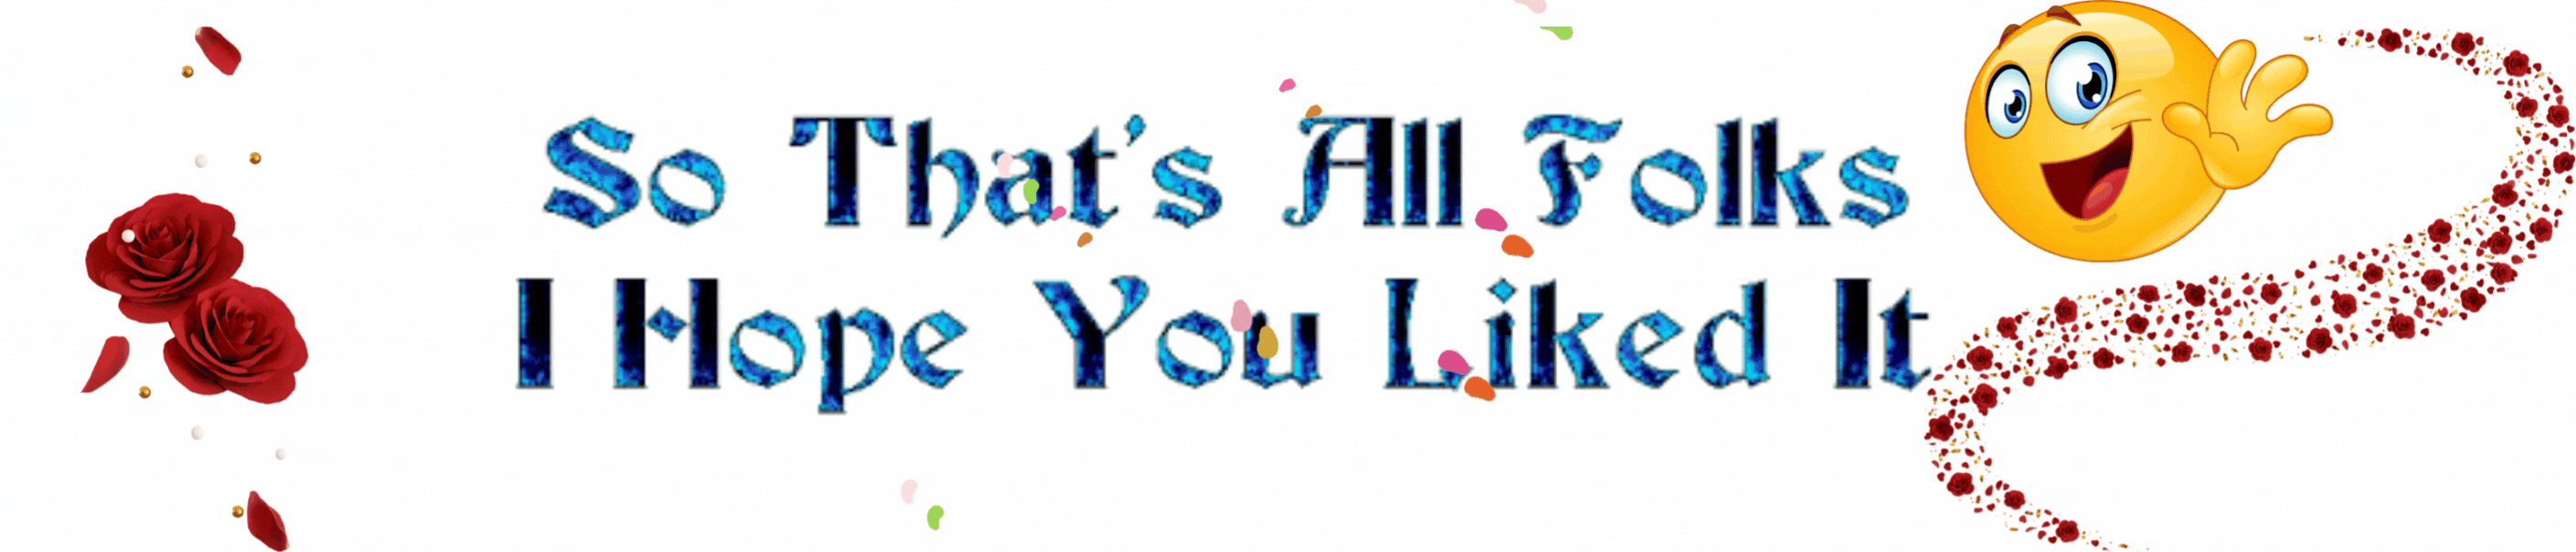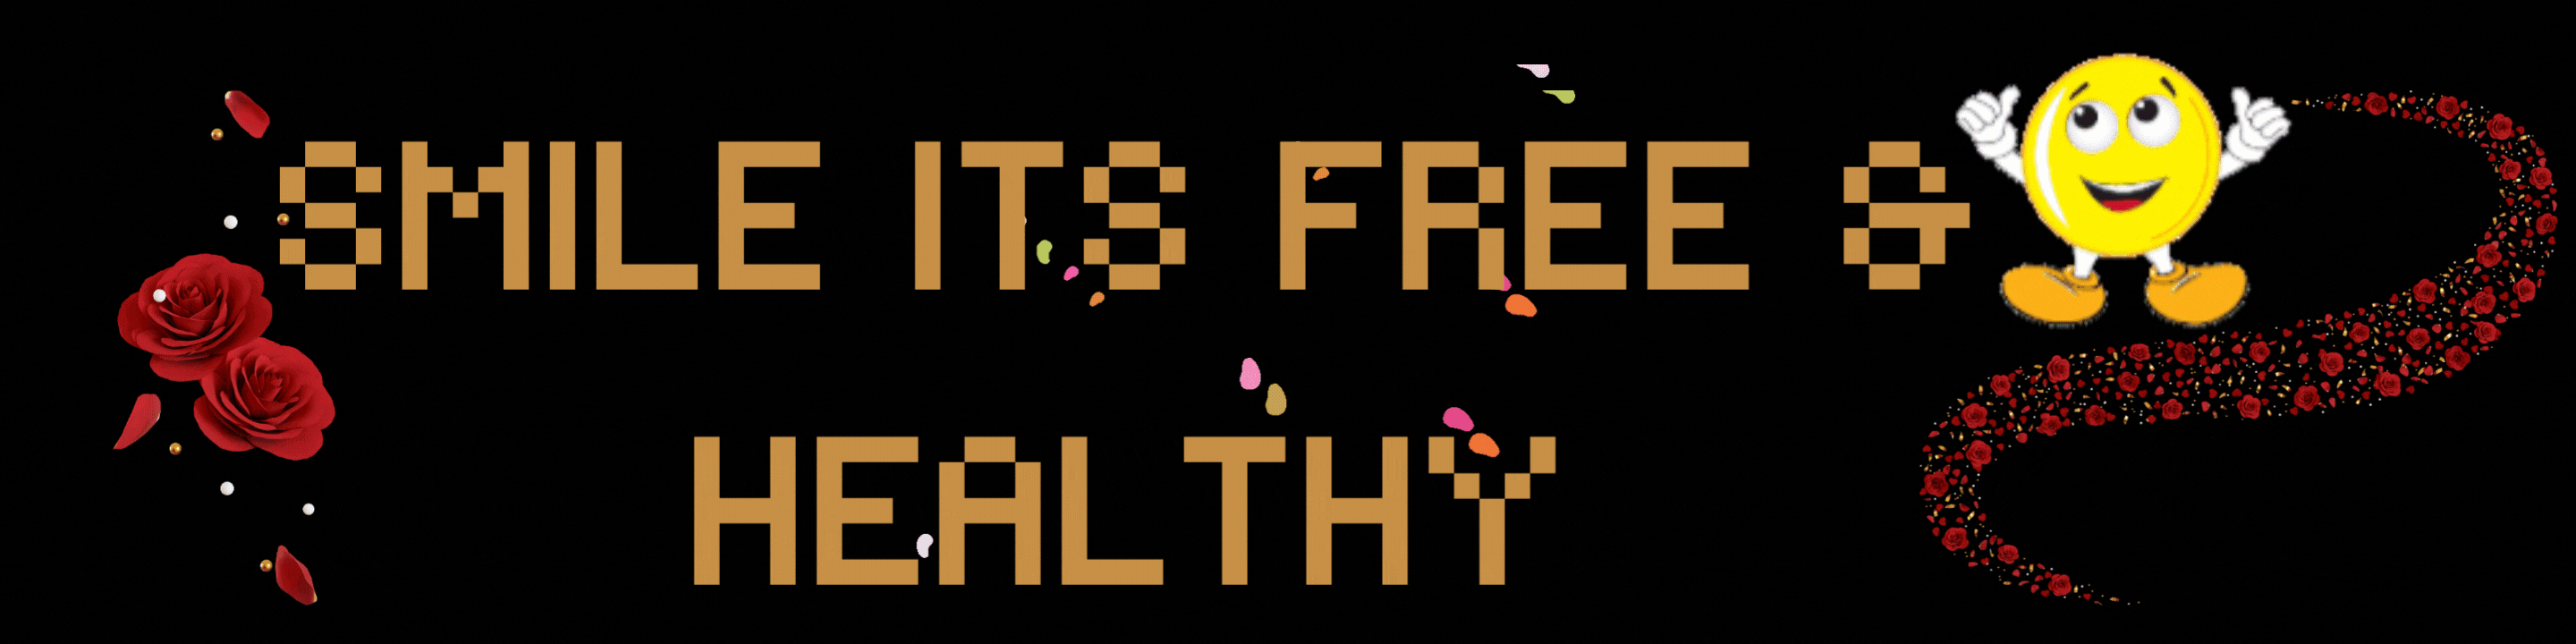)

Helpful Resources:
* https://neo4j.com/cloud/platform/aura-graph-database/
* https://python.langchain.com/docs/use_cases/graph/graph_cypher_qa
* https://github.com/Foutse/Neo4j_experiences/tree/main/dataset_movie